# Testing corrected y_pred

In [330]:
%load_ext autoreload
%autoreload 2

import utils
import run

import numpy as np
import torch
import matplotlib.pyplot as plt

# test config
config = run.make_config('configs/horizonlstm_default.yaml') # window 100, horizon 10
config['model'].load_state_dict(torch.load('models/horizonlstm_default_16-11-2023_16-51-51/horizonlstm_default_16-11-2023_16-51-51_e600.p')['model_state_dict'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
using cpu


<All keys matched successfully>

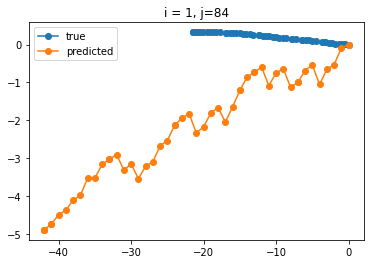

In [379]:
def visualize_differences(config, i=None, j=None, ax=None):
    model = config['model']
    if i is None:
        i = np.random.randint(len(config['train_datasets']))
    if j is None:
        j = np.random.randint(len(config['train_datasets'][i]))
    x, y, m = config['train_datasets'][i][j]
    m = m.bool().unsqueeze(-1).expand(-1, y.shape[-1]).detach().numpy()
    
    y_pred, _ = model(x)
    y_pred = y_pred[:, -2:].detach().numpy()
    y_pred *= m
    y *= m
    y = y.detach().numpy()
    
    y, y_pred, m = y[-config['horizon']:], y_pred[-config['horizon']:], m[-config['horizon']:]
    
    y_traj = y.cumsum(axis=0)
    y_pred_traj = y_pred.cumsum(axis=0)

    y_corrected = utils.get_corrected_y_for_delta_p(y, y_pred, m)

    y_traj_x = [0, *y_traj[:, 0]]
    y_traj_y = [0, *y_traj[:, 1]]

    y_pred_traj_x = [0, *y_pred_traj[:, 0]]
    y_pred_traj_y = [0, *y_pred_traj[:, 1]]

    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(y_traj_x, y_traj_y, "-o", label='true')
    ax.plot(y_pred_traj_x, y_pred_traj_y, "-o", label='predicted')
    #for k in range(y_corrected.shape[0]):
    #    ax.plot([y_pred_traj_x[k], y_pred_traj_x[k] + y_corrected[k, 0]], [y_pred_traj_y[k], y_pred_traj_y[k] + y_corrected[k, 1]])
    ax.legend()
    ax.set_title(f'i = {i}, j={j}')
    return y, y_pred, y_traj, y_pred_traj, y_pred_corrected

y, y_pred, y_traj, y_pred_traj, y_corrected = visualize_differences(config)#, 0, 17030) #, 0, 5707)
#y, y_pred, y_traj, y_pred_traj, y_pred_corrected